In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [2]:
def conf_sorting(row):
    if 0 <= row['prob_of_growth'] <= 0.1 :
        val = 1
    elif 0.1 < row['prob_of_growth'] <= 0.2 :
        val = 2
    elif 0.2 < row['prob_of_growth'] <= 0.3 :
        val = 3
    elif 0.3 < row['prob_of_growth'] <= 0.4 :
        val = 4
    elif 0.4 < row['prob_of_growth'] <= 0.5 :
        val = 5
    elif 0.5 < row['prob_of_growth'] <= 0.6 :
        val = 6
    elif 0.6 < row['prob_of_growth'] <= 0.7 :
        val = 7    
    elif 0.7 < row['prob_of_growth'] <= 0.8 :
        val = 8
    elif 0.8 < row['prob_of_growth'] <= 0.9 :
        val = 9
    elif 0.9 < row['prob_of_growth'] <= 1 :
        val = 10
    
    return val

# ВЫГРУЖАЕМ ДАННЫЕ 


In [2]:
df = pd.read_csv('/windows/proga/global_mfdexport_1month_18072010_18072023.txt',sep=';')\
    .rename(columns={'<DATE>':'DATE','<OPEN>':'OPEN','<LOW>':'LOW','<CLOSE>':'CLOSE','<VOL>':'VOL','<HIGH>':'HIGH','<TICKER>':'TICKER'})\
    .drop(['<PER>','<TIME>','<OPENINT>'],1)
df.DATE = pd.to_datetime(df.DATE,format="%Y%m%d")
companies = df['TICKER'].unique()

In [3]:
df

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,ГАЗПРОМ ао,2010-07-01,155.1,167.00,154.09,162.85,420544096
1,ГАЗПРОМ ао,2010-08-01,164.0,170.64,154.72,159.15,918015245
2,ГАЗПРОМ ао,2010-09-01,159.6,167.39,155.71,160.00,908142983
3,ГАЗПРОМ ао,2010-10-01,160.0,171.40,159.47,168.89,1149986334
4,ГАЗПРОМ ао,2010-11-01,170.0,177.44,165.60,174.20,1001199729
...,...,...,...,...,...,...,...
5039,FIXP-гдр,2023-03-01,357.5,358.00,334.00,348.60,1492624
5040,FIXP-гдр,2023-04-01,348.6,373.60,344.00,352.60,2361168
5041,FIXP-гдр,2023-05-01,352.8,372.80,340.00,363.90,2237586
5042,FIXP-гдр,2023-06-01,365.0,407.30,353.80,376.00,7281951


# ВЫБОР АКТИВА И ПОДГОТОВКА ДАННЫХ

In [4]:
company_df = df.loc[df['TICKER'] == 'Полюс']
#company_df['earn'] = (company_df.CLOSE-company_df.CLOSE.shift(1).fillna(0))/company_df.CLOSE.shift(1).fillna(0)
company_df['earn'] = company_df.CLOSE.pct_change()
#company_df.replace([np.inf, -np.inf], 100, inplace=True)
#company_df = company_df.loc[company_df.earn != 100]
series = company_df[['DATE','earn']].set_index('DATE')

In [5]:
#Делаем train и test выборки
historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
test = series.earn.iloc[int(len(series) * 0.7):]

In [9]:
upper_conf_int = []
lower_conf_int = []
predictions = []
probabilities = []
for i in range(len(test)):
    res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
    model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
    model_results = model.fit()
#------РАСЧЁТ ВЕРОЯТНОСТИ ПОЛОЖИТЕЛЬНОЙ ДОХОДНОСТИ------------    
    #список AR коэффициентов
    ar_params = model_results.arparams
    #делаем срез с хвоста train выборки длиной равной количеству AR коэффициентов
    ar_obs = np.array( historic[-len(ar_params):][::-1] )
    # Скалярно перемножаем их , получаем сумму произведений предыдущих значений и их коэффициентов
    if len(ar_params) != 0 :
        ar_part = np.dot(ar_params , ar_obs)
    elif len(ar_params) == 0 :
        ar_part = 0
    #список MA коэффициентов
    ma_params = model_results.maparams
    #делаем срез с хвоста train выборки длиной равной количеству MA коэффициентов
    ma_obs = np.array( model_results.resid[-len(ma_params):][::-1] )
    # Скалярно перемножаем их , получаем сумму произведений предыдущих значений и их коэффициентов
    if len(ma_params) != 0 :
        ma_part = np.dot(ma_params , ma_obs)
    elif len(ma_params) == 0 :
        ma_part = 0
    #Константа
    const = model_results.params[0]
    #Mu
    mu = ar_part+ma_part+const
    #STD
    std = np.sqrt(model_results.params[-1])
    #Сама вероятость положительной доходности в будущем месяце
    probability_of_growth = norm.cdf(mu/std, loc = 0, scale = 1)
#-----------------------------------------------------------------------    
    arma_forecast = model_results.get_forecast(1)
    arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
    pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    probabilities.append(probability_of_growth)
    upper_conf_int.append(arma_predictions_df[0][1])
    lower_conf_int.append(arma_predictions_df[0][0])
    historic.append(test[i])
probabilities = pd.DataFrame(probabilities).set_index(test.index)    
predictions = pd.DataFrame(predictions).set_index(test.index)
upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)

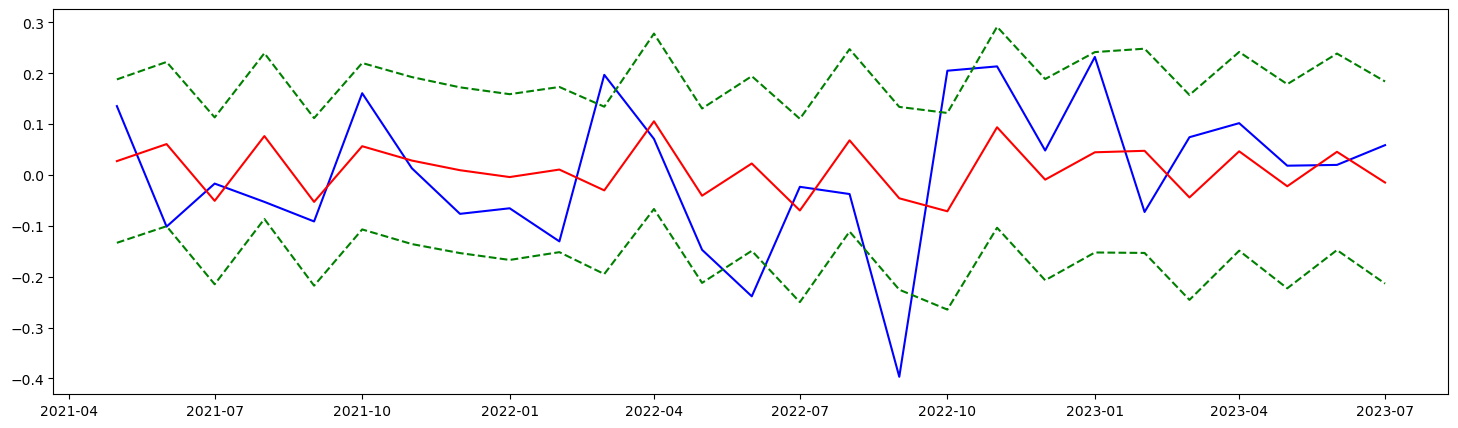

In [10]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test, color = "blue", label = "Тестовая выборка")

plt.plot(predictions, color = "red", label = "Прогноз")
plt.plot(upper_conf_int, color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(lower_conf_int, color = "green", linestyle = "--")

### ОЦЕНКА КАЧЕСТВА МОДЕЛИ

In [13]:
#Рассёт качества модели : MSE, MAE, Hit-Rate  

#MSE среднеквардратическая ошибка
test_score = mean_squared_error(test, predictions)
#MAE средняяабсолютная ошибка
mae = round(abs(test.values - predictions.values).mean(),10)
#Склеиваем DF'ы
price_pred = pd.concat([test ,lower_conf_int, predictions , upper_conf_int , probabilities ], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'lower','pred','upper','prob_of_growth']
#Hit-Rate доля угаданных направлений
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['pred']), 1, 0)
price_pred['out_of_conf_int'] = np.where( (price_pred['Price']<price_pred['lower']) + (price_pred['Price']>price_pred['upper']) ,1,0)
#Результирующее сообщение
hit_rate = round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)
out_of_ci = round(price_pred['out_of_conf_int'].sum() / price_pred['out_of_conf_int'].count() * 100 , 2 )
print('MSE: %.5f' % test_score)
print(f'MAE is {mae}')
print(f"Hit rate: {hit_rate}%")
print(f"Out of CI: {out_of_ci}%")

MSE: 0.01989
MAE is 0.1177788946
Hit rate: 51.85%
Out of CI: 18.52%


### Введём колонку , которая определяет вероятность роста в одну из десяти категорий по степени уверенности в будущем росте 


In [14]:
price_pred['confidence_of_growth'] = price_pred.apply(conf_sorting ,axis=1)

In [15]:
df_for_plot = price_pred.groupby('confidence_of_growth',as_index=False).aggregate({'hit':'sum'})

In [16]:
df_for_plot

,confidence_of_growth,hit
0,3,5
1,4,0
2,5,1
3,6,4
4,7,1
5,8,1
6,9,2


Text(0, 0.5, 'Количество Хитов , случившихся на этих интервалах')

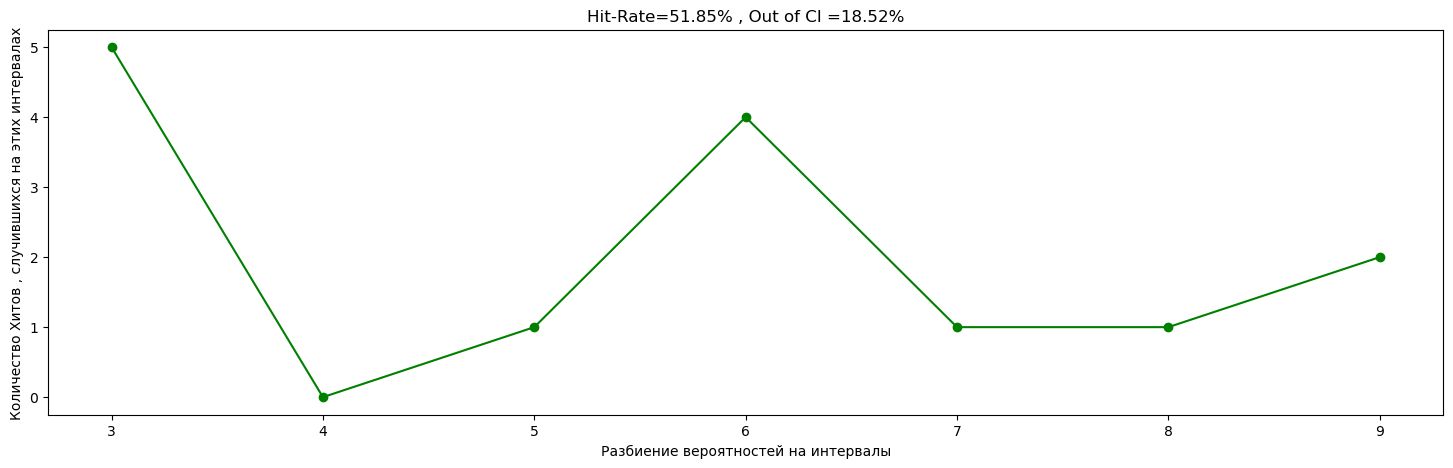

In [18]:
plt.plot(df_for_plot.confidence_of_growth, df_for_plot.hit,'-go')
plt.title(f"Hit-Rate={hit_rate}% , Out of CI ={out_of_ci}%")
plt.xlabel('Разбиение вероятностей на интервалы')
plt.ylabel('Количество Хитов , случившихся на этих интервалах')
#plt.savefig(f"{j}.png")

# ОБЩИЙ ПРОГОН ВСЕХ АКТИВОВ

In [4]:
for j in companies:
    #Создаём дф и временной ряд доходностей
    company_df = df.loc[df['TICKER'] == j]
    company_df['earn'] = company_df.CLOSE.pct_change()
    series = company_df[['DATE','earn']].set_index('DATE')
    
    #Делаем train и test выборки
    historic = series.earn.iloc[:int(len(series) * 0.7)].to_list()
    test = series.earn.iloc[int(len(series) * 0.7):]
    
    
    upper_conf_int = []
    lower_conf_int = []
    predictions = []
    probabilities = []
    for i in range(len(test)):
        res = statsmodels.tsa.stattools.arma_order_select_ic(historic, ic=["aic", "bic"])
        model = ARIMA(historic, order=(res.aic_min_order[0] , 0 , res.aic_min_order[1]) )
        model_results = model.fit()
#------РАСЧЁТ ВЕРОЯТНОСТИ ПОЛОЖИТЕЛЬНОЙ ДОХОДНОСТИ------------    
        #список AR коэффициентов
        ar_params = model_results.arparams
        #делаем срез с хвоста train выборки длиной равной количеству AR коэффициентов
        ar_obs = np.array( historic[-len(ar_params):][::-1] )
        # Скалярно перемножаем их , получаем сумму произведений предыдущих значений и их коэффициентов
        if len(ar_params) != 0 :
            ar_part = np.dot(ar_params , ar_obs)
        elif len(ar_params) == 0 :
            ar_part = 0
        #список MA коэффициентов
        ma_params = model_results.maparams
        #делаем срез с хвоста train выборки длиной равной количеству MA коэффициентов
        ma_obs = np.array( model_results.resid[-len(ma_params):][::-1] )
        # Скалярно перемножаем их , получаем сумму произведений предыдущих значений и их коэффициентов
        if len(ma_params) != 0 :
            ma_part = np.dot(ma_params , ma_obs)
        elif len(ma_params) == 0 :
            ma_part = 0
        #Константа
        const = model_results.params[0]
        #Mu
        mu = ar_part+ma_part+const
        #STD
        std = np.sqrt(model_results.params[-1])
        #Сама вероятость положительной доходности в будущем месяце
        probability_of_growth = norm.cdf(mu/std, loc = 0, scale = 1)
#-----------------------------------------------------------------------    
        arma_forecast = model_results.get_forecast(1)
        arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
        pred = model_results.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        probabilities.append(probability_of_growth)
        upper_conf_int.append(arma_predictions_df[0][1])
        lower_conf_int.append(arma_predictions_df[0][0])
        historic.append(test[i])
    probabilities = pd.DataFrame(probabilities).set_index(test.index)    
    predictions = pd.DataFrame(predictions).set_index(test.index)
    upper_conf_int = pd.DataFrame(upper_conf_int).set_index(test.index)   
    lower_conf_int = pd.DataFrame(lower_conf_int).set_index(test.index)          
    
    
    #Рассёт качества модели : MSE, MAE, Hit-Rate  

    #MSE среднеквардратическая ошибка
    test_score = mean_squared_error(test, predictions)
    #MAE средняяабсолютная ошибка
    mae = round(abs(test.values - predictions.values).mean(),10)
    #Склеиваем DF'ы
    price_pred = pd.concat([test ,lower_conf_int, predictions , upper_conf_int , probabilities ], axis=1)
    price_pred.dropna(inplace=True)
    price_pred.columns = ['Price', 'lower','pred','upper','prob_of_growth']
    #Hit-Rate доля угаданных направлений
    price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['pred']), 1, 0)
    price_pred['out_of_conf_int'] = np.where( (price_pred['Price']<price_pred['lower']) + (price_pred['Price']>price_pred['upper']) ,1,0)
    price_pred['confidence_of_growth'] = price_pred.apply(conf_sorting ,axis=1)
    
    hit_rate = round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)
    out_of_ci = round(price_pred['out_of_conf_int'].sum() / price_pred['out_of_conf_int'].count() * 100 , 2 )
    #сохраняем hit-plot
    df_for_plot = price_pred.groupby('confidence_of_growth',as_index=False).aggregate({'hit':'sum'})
    plt.rcParams["figure.figsize"] = 18, 5
    plt.plot(df_for_plot.confidence_of_growth, df_for_plot.hit,'-go')
    plt.title(f"Актив-{j}  ,  Hit-Rate={hit_rate}%  ,  Out of CI ={out_of_ci}%")
    plt.xlabel('Разбиение вероятностей на интервалы')
    plt.ylabel('Кол-во угаданных направлений доходности , случившихся на этих интервалах')
    plt.savefig(f"{j}.png")
    plt.clf()
    print(f"Актив{j}")
    print('MSE: %.5f' % test_score)
    print(f'MAE is {mae}')
    print(f"Hit rate: {hit_rate}%")
    print(f"Out of CI: {out_of_ci}%")

АктивГАЗПРОМ ао
MSE: 0.01365
MAE is 0.084892854
Hit rate: 47.92%
Out of CI: 18.75%
АктивСбербанк
MSE: 0.01404
MAE is 0.078170265
Hit rate: 62.5%
Out of CI: 8.33%
АктивЛУКОЙЛ
MSE: 0.01124
MAE is 0.0823680719
Hit rate: 52.08%
Out of CI: 22.92%
АктивГМКНорНик
MSE: 0.00581
MAE is 0.0611318435
Hit rate: 58.33%
Out of CI: 4.17%
АктивМагнит ао
MSE: 0.01298
MAE is 0.0865139763
Hit rate: 56.25%
Out of CI: 8.33%
АктивТатнфт 3ао
MSE: 0.01075
MAE is 0.0809581287
Hit rate: 45.83%
Out of CI: 16.67%
АктивНоватэк ао
MSE: 0.01280
MAE is 0.0885291146
Hit rate: 52.08%
Out of CI: 14.58%
АктивСургнфгз
MSE: 0.01416
MAE is 0.0885245941
Hit rate: 58.33%
Out of CI: 10.42%
АктивПолюс
MSE: 0.01989
MAE is 0.1177788946
Hit rate: 51.85%
Out of CI: 18.52%
АктивСургнфгз-п
MSE: 0.01086
MAE is 0.0822780324
Hit rate: 52.08%
Out of CI: 16.67%
АктивПИК ао
MSE: 0.01780
MAE is 0.0922288617
Hit rate: 64.58%
Out of CI: 16.67%
АктивРоснефть
MSE: 0.01974
MAE is 0.0982796187
Hit rate: 47.92%
Out of CI: 22.92%
АктивСбербанк-п
MSE

<Figure size 1800x500 with 0 Axes>

# ОЦЕНКА ВЕРОЯТНОСТИ ПОСЛЕДНЕГО ПРОГНОЗА

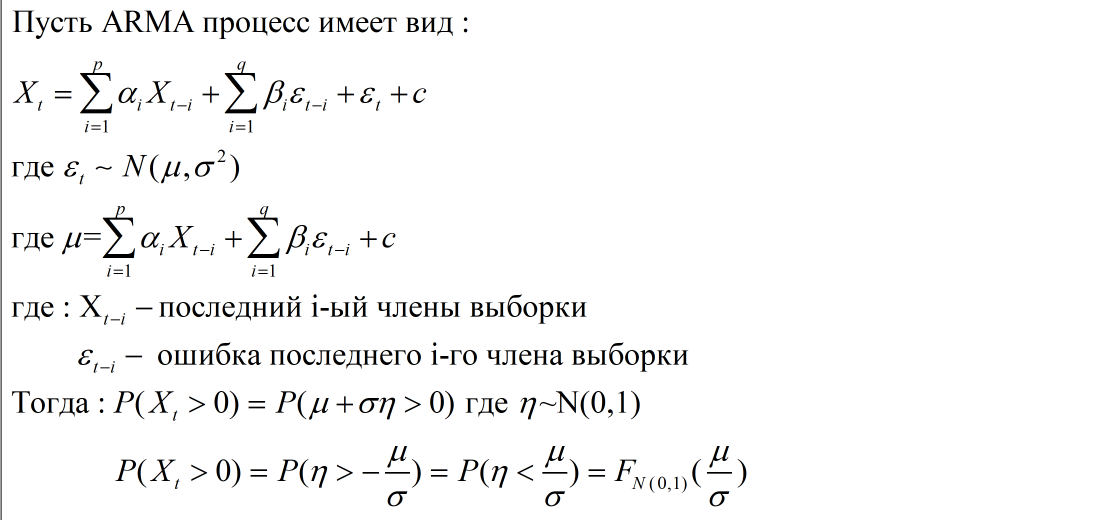

In [11]:
from IPython.display import Image
Image("/home/daniil/Изображения/Снимки экрана/arma_mathtype.png")